<a href="https://colab.research.google.com/github/shesh40bears/cropguard/blob/main/cropguard_densenet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.preprocessing import image
from sklearn.utils import class_weight
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

import seaborn as sns
# from keras.utils import np_utils
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/MyDrive/cropguard-dataset.zip

Archive:  /content/gdrive/MyDrive/cropguard-dataset.zip
   creating: cropguard-dataset/
  inflating: cropguard-dataset/.DS_Store  
  inflating: __MACOSX/cropguard-dataset/._.DS_Store  
   creating: cropguard-dataset/Rice___Leaf_Smut/
   creating: cropguard-dataset/Rice___Leaf_Scald/
   creating: cropguard-dataset/Rice___Hispa/
   creating: cropguard-dataset/Rice___Healthy/
   creating: cropguard-dataset/Rice___Blast/
   creating: cropguard-dataset/Rice___Brown_Spot/
   creating: cropguard-dataset/Rice___Sheath_Blight/
   creating: cropguard-dataset/Rice___Tungro/
   creating: cropguard-dataset/Rice___Bacterial_Leaf_Blight/
  inflating: cropguard-dataset/Rice___Leaf_Smut/5390514.jpg  
  inflating: cropguard-dataset/Rice___Leaf_Smut/5356989.jpg  
  inflating: cropguard-dataset/Rice___Leaf_Smut/DSC_0331.JPG  
  inflating: cropguard-dataset/Rice___Leaf_Smut/DSC_0319.jpg  
  inflating: cropguard-dataset/Rice___Leaf_Smut/DSC_0293.JPG  
  inflating: cropguard-dataset/Rice___Leaf_Smut/DSC_0318

In [4]:
data_dir = '/content/cropguard-dataset'
categories = os.listdir(data_dir)

In [5]:
DATA_DIRECTORY = data_dir
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
CHANNELS = 3
SEED = 1337
TRAIN = 0.8
VALIDATION = 0.1
TEST = 0.1
COLOR_MODE = 'rgb'
CLASS_MODE = 'categorical'
WEIGHTS = 'imagenet'
POOLING = 'avg'
ACTIVATION = 'softmax'
MONITOR = 'loss'
PATIENCE = 3
VERBOSE = 1
FACTOR = 0.1
MIN_LR = 0.0000000001
LR = 0.00001
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy']

In [6]:
plant_disease_pairs = list()

for directory in os.listdir(path=DATA_DIRECTORY):
  if not directory.startswith('.DS_Store'):
    columns = directory.split('___')
    columns.append(directory)

    sub_path = DATA_DIRECTORY + '/' + directory
    columns.append(len([name for name in os.listdir(path=sub_path)]))

    plant_disease_pairs.append(columns)

plant_disease_pairs = pd.DataFrame(plant_disease_pairs, columns=['Plant Name', 'Disease Name', 'Directory', 'File Count'])
plant_disease_pairs.sort_values(by='Plant Name')

,Plant Name,Disease Name,Directory,File Count
0,Rice,Brown_Spot,Rice___Brown_Spot,702
1,Rice,Hispa,Rice___Hispa,565
2,Rice,Bacterial_Leaf_Blight,Rice___Bacterial_Leaf_Blight,40
3,Rice,Leaf_Smut,Rice___Leaf_Smut,44
4,Rice,Sheath_Blight,Rice___Sheath_Blight,283
5,Rice,Leaf_Scald,Rice___Leaf_Scald,217
6,Rice,Blast,Rice___Blast,1051
7,Rice,Tungro,Rice___Tungro,195
8,Rice,Healthy,Rice___Healthy,1488


In [7]:
!pip install split_folders
import splitfolders

splitfolders.ratio(
    input=DATA_DIRECTORY,
    output="./",
    seed=SEED,
    ratio=(TRAIN, VALIDATION, TEST),
    group_prefix=None
)

Copying files: 4585 files [01:43, 44.18 files/s]


In [8]:
number_of_classes = len(os.listdir(r'./test'))

train_data_instance = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_data_generator = train_data_instance.flow_from_directory(
    r'./train',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 3665 images belonging to 9 classes.


In [9]:
valid_data_instance = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

valid_data_generator = valid_data_instance.flow_from_directory(
    r'./val',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 455 images belonging to 9 classes.


In [10]:
base_model = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS),
    pooling='avg'
)

model = keras.models.Sequential([
    base_model,
    keras.layers.Dense(
        number_of_classes,
        activation='softmax'
    )
])

print(model.summary())

74836368/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense (Dense)               (None, 9)                 17289     
                                                                 
Total params: 18339273 (69.96 MB)
Trainable params: 18110217 (69.08 MB)
Non-trainable params: 229056 (894.75 KB)
_________________________________________________________________
None


In [11]:
early_stop=EarlyStopping(patience=3)

reduce_learning_rate=ReduceLROnPlateau(
    monitor='loss',
    patience=2,
    verbose=1,
    factor=0.1,
    min_lr=0.0000000001
)

train_callbacks=[reduce_learning_rate]

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

train_steps_size = train_data_generator.n // train_data_generator.batch_size
valid_steps_size = valid_data_generator.n // valid_data_generator.batch_size

print('Step Size of Training: ', train_steps_size)
print('Step Size of Validation: ', valid_steps_size)

Step Size of Training:  114
Step Size of Validation:  14


In [ ]:
model_history = model.fit_generator(
    generator=train_data_generator,
    steps_per_epoch=train_steps_size,
    validation_data=valid_data_generator,
    validation_steps=valid_steps_size,
    epochs=100,
    callbacks=train_callbacks
)

<ipython-input-14-838c7b25edcb>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/100
  2/114 [..............................] - ETA: 1:07:33 - loss: 2.5453 - accuracy: 0.1875

In [ ]:
saved_model_json = model.to_json()

with open("DenseNet201_Model.json", "w") as json_file:
    json_file.write(saved_model_json)
model.save_weights("DenseNet201_Weights.h5")

print("Model and weights saved to disk successfully")

In [ ]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})
plt.plot(model_history.history['accuracy'], label='Training')
plt.plot(model_history.history['val_accuracy'], label='Validation')
plt.title('Accuracy During Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

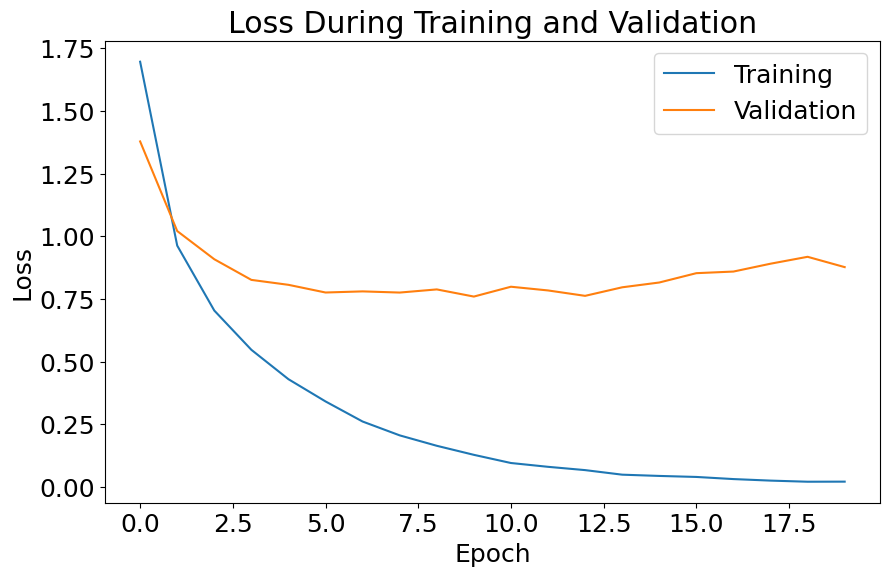

In [16]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})
plt.plot(model_history.history['loss'], label='Training')
plt.plot(model_history.history['val_loss'], label='Validation')
plt.title('Loss During Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [17]:
test_data_instance=ImageDataGenerator(
    preprocessing_function=preprocess_input
)

prediction_directory = r'./test'
test_data_generator = test_data_instance.flow_from_directory(
    directory=prediction_directory,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)


Found 465 images belonging to 9 classes.


In [18]:
test_steps_size = test_data_generator.n / BATCH_SIZE

model_prediction = model.predict_generator(
    test_data_generator,
    verbose=1,
    steps=test_steps_size
)

predicted_indices = np.argmax(model_prediction, axis=1)
class_indices = (train_data_generator.class_indices)
labels = dict((v, k) for k, v in class_indices.items())
predictions = [labels[k] for k in predicted_indices]
filenames = test_data_generator.filenames
results = pd.DataFrame({"Filename": filenames, "Predictions": predictions})
print(results)

<ipython-input-18-8520825d89e3>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  model_prediction = model.predict_generator(


14/14 [==============================] - 38s 2s/step
                                      Filename                   Predictions
0    Rice___Bacterial_Leaf_Blight/DSC_0393.JPG  Rice___Bacterial_Leaf_Blight
1    Rice___Bacterial_Leaf_Blight/DSC_0405.JPG  Rice___Bacterial_Leaf_Blight
2    Rice___Bacterial_Leaf_Blight/DSC_0700.jpg              Rice___Leaf_Smut
3    Rice___Bacterial_Leaf_Blight/DSC_0703.JPG  Rice___Bacterial_Leaf_Blight
4         Rice___Blast/IMG_20190419_100614.jpg                Rice___Healthy
..                                         ...                           ...
460                   Rice___Tungro/rtf_53.jpg             Rice___Leaf_Scald
461                   Rice___Tungro/rtf_62.jpg             Rice___Leaf_Scald
462                   Rice___Tungro/rtf_65.jpg                 Rice___Tungro
463                   Rice___Tungro/rtf_70.jpg                 Rice___Tungro
464                   Rice___Tungro/rtf_74.jpg                 Rice___Tungro

[465 rows x 2 columns]

In [19]:
true_prediction = 0
false_prediction = 0

filename_array = []
prediction_array = []

for index, row in results.iterrows():
    filename_array.append(row['Filename'].split('/')[0])
    prediction_array.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        true_prediction += 1
    else:
        false_prediction += 1

print("Number of correct predictions:", true_prediction)
print("Number of incorrect predictions:", false_prediction)

Number of correct predictions: 355
Number of incorrect predictions: 110


In [20]:
label_encoder = LabelEncoder()
test_y = label_encoder.fit_transform(filename_array)
prediction_y = label_encoder.fit_transform(prediction_array)

test_labels_encoded = test_y
prediction_labels_encoded = prediction_y

test_y = np_utils.to_categorical(test_y, number_of_classes)
prediction_y = np_utils.to_categorical(prediction_y, number_of_classes)

print("Classification Report: \n\n", classification_report(test_y, prediction_y))

Classification Report: 

               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.84      0.76      0.80       106
           2       0.79      0.70      0.75        71
           3       0.78      0.91      0.84       150
           4       0.62      0.49      0.55        57
           5       0.54      0.57      0.55        23
           6       0.71      1.00      0.83         5
           7       0.83      0.86      0.85        29
           8       0.64      0.70      0.67        20

   micro avg       0.76      0.76      0.76       465
   macro avg       0.75      0.75      0.74       465
weighted avg       0.76      0.76      0.76       465
 samples avg       0.76      0.76      0.76       465



In [21]:
from sklearn.metrics import accuracy_score

test_score = accuracy_score(test_y, prediction_y)
print(f"Accuracy Score: {test_score*100:.5f}%")

Accuracy Score: 76.34409%


In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(test_labels_encoded, prediction_labels_encoded)
class_accuracy = confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)

for i in range(len(class_accuracy)):
    print('Class Index: ', i, '\t', 'Class Accuracy:', class_accuracy[i])

Class Index:  0 	 Class Accuracy: 0.75
Class Index:  1 	 Class Accuracy: 0.7641509433962265
Class Index:  2 	 Class Accuracy: 0.704225352112676
Class Index:  3 	 Class Accuracy: 0.9066666666666666
Class Index:  4 	 Class Accuracy: 0.49122807017543857
Class Index:  5 	 Class Accuracy: 0.5652173913043478
Class Index:  6 	 Class Accuracy: 1.0
Class Index:  7 	 Class Accuracy: 0.8620689655172413
Class Index:  8 	 Class Accuracy: 0.7


<Axes: >

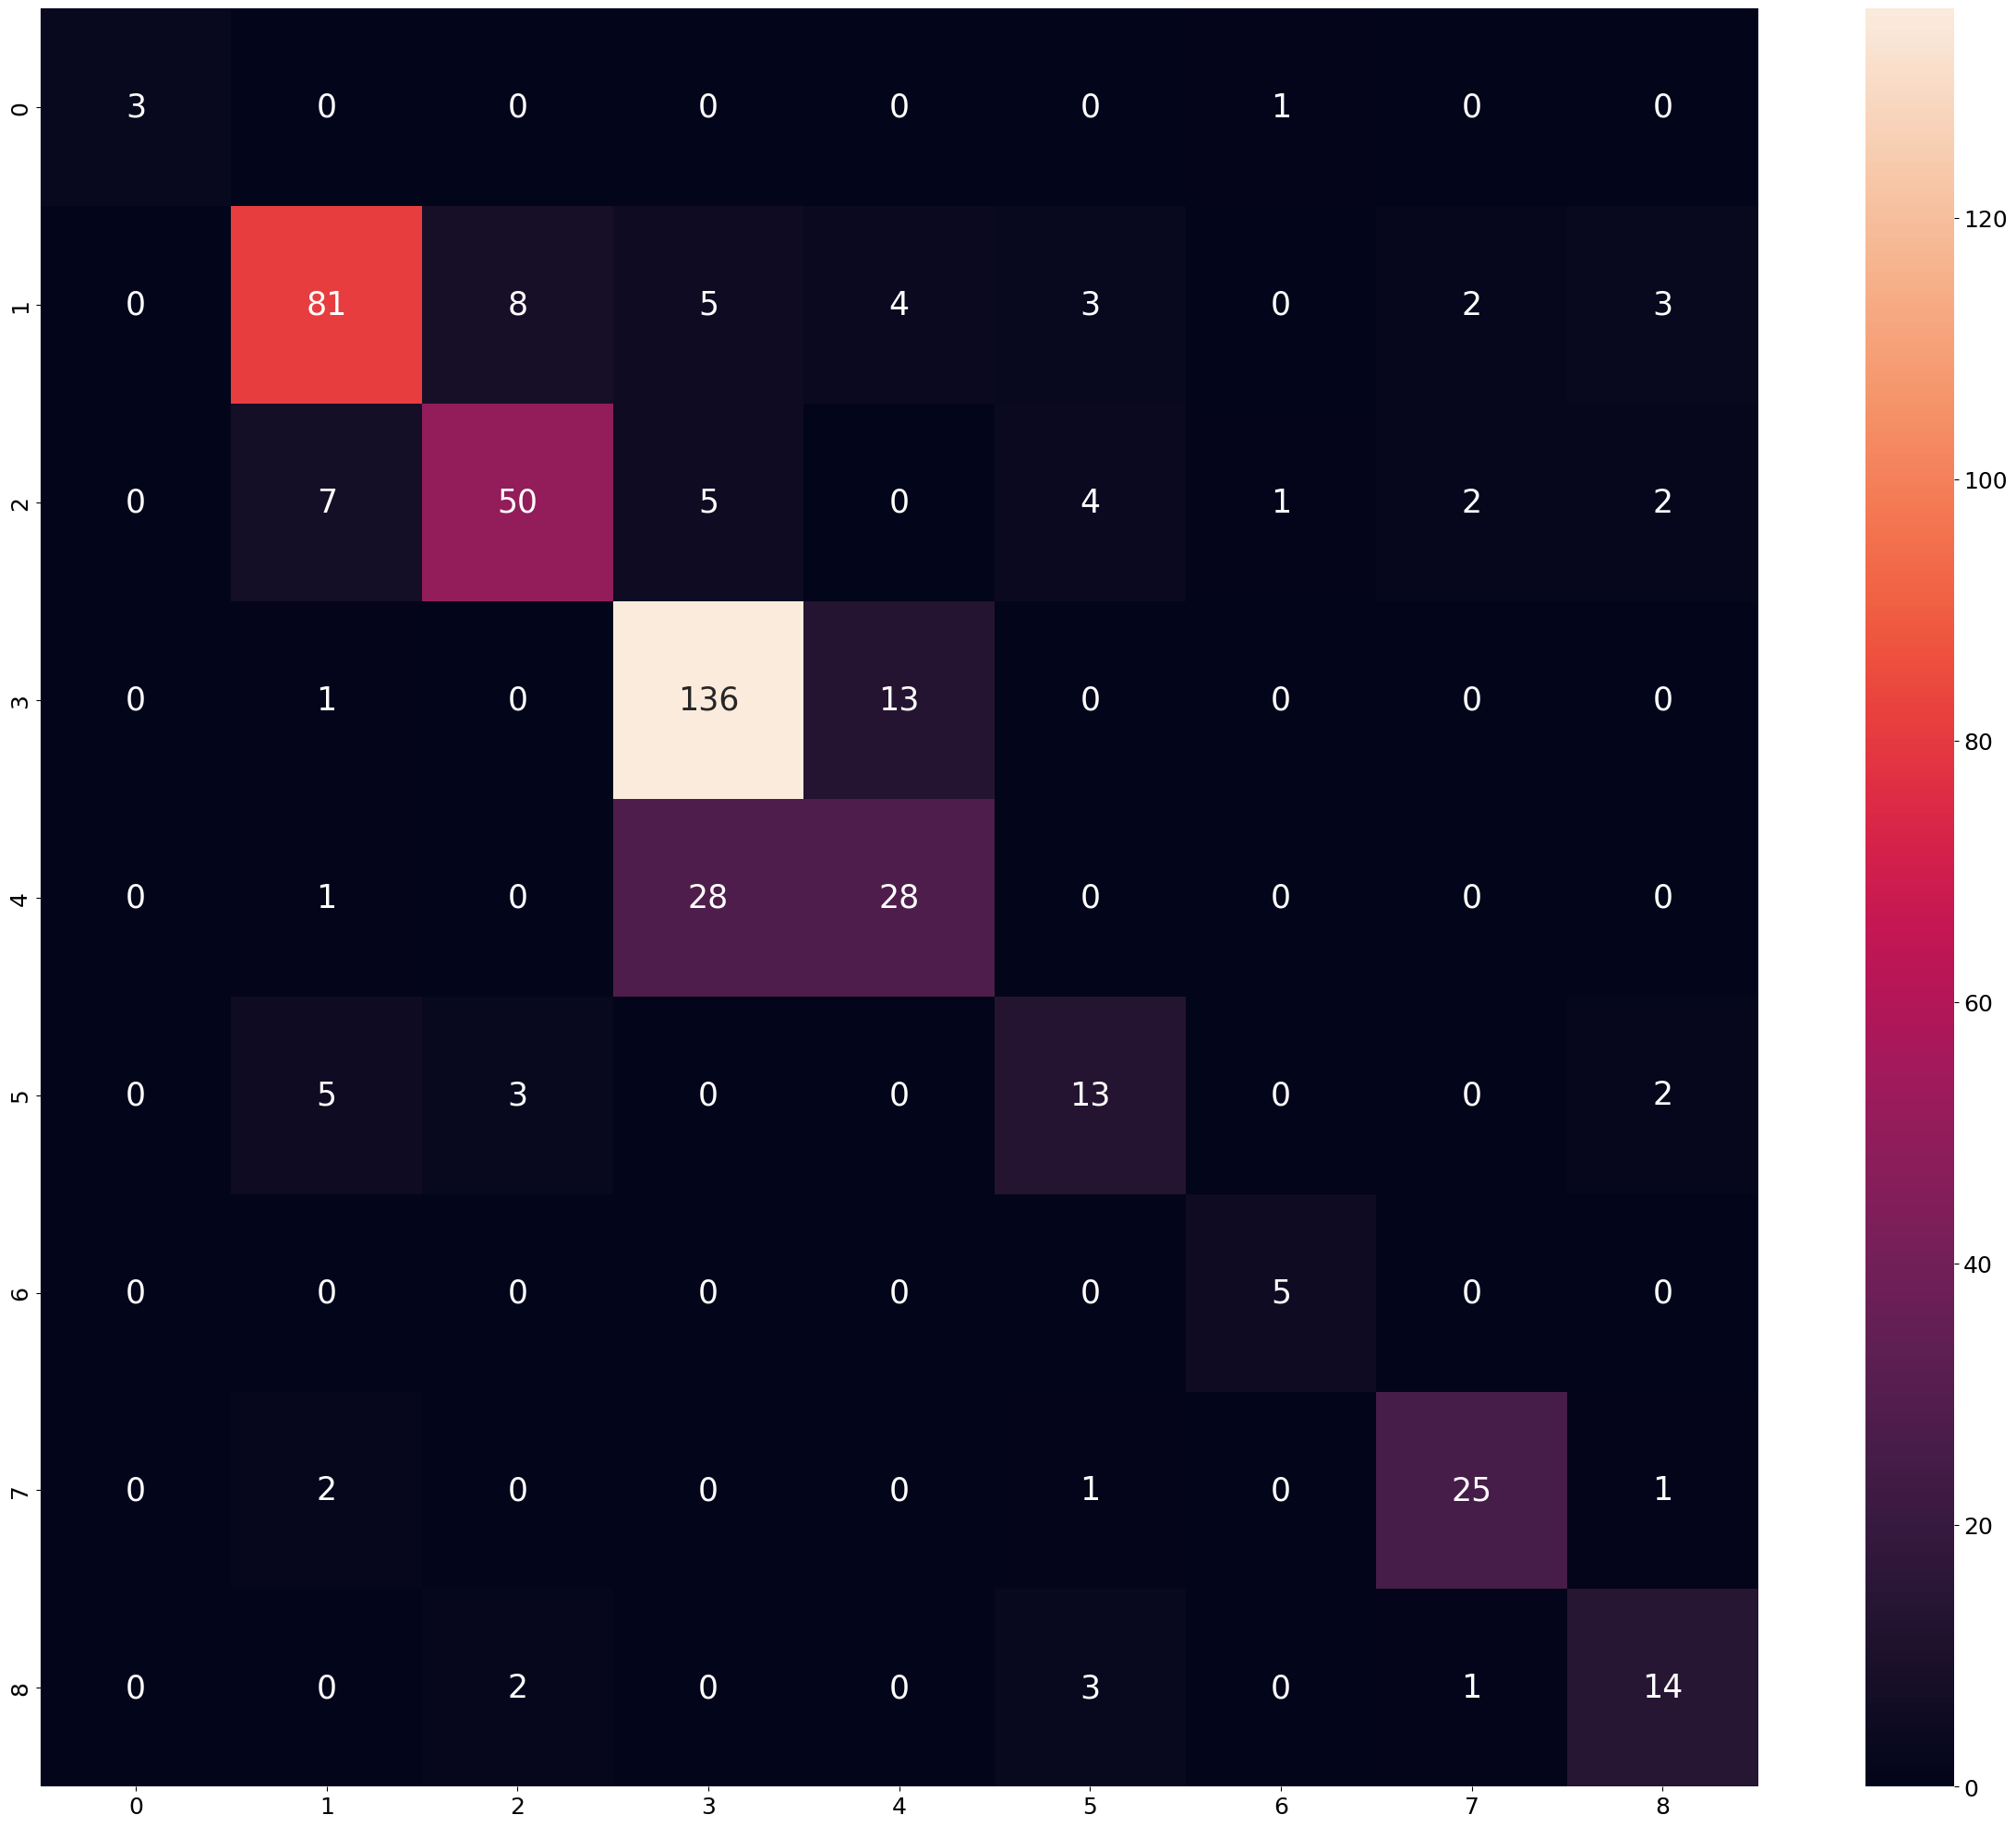

In [23]:
plt.figure(figsize=(30,25))
sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 25}, fmt='d')

In [ ]:
model.save("DenseNet201_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = keras.models.load_model("DenseNet201_Model.h5")
loaded_model